In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/santander-customer-satisfaction/sample_submission.csv
/kaggle/input/santander-customer-satisfaction/train.csv
/kaggle/input/santander-customer-satisfaction/test.csv


# **Santander Customer Satisfaction**

**Santander Bank**, headquartered in Spain, is one of the largest banks in the world with a presence in 10 core markets. With over 190,000 employees serving 150 million customers, Santander is committed to customer satisfaction and experience.

Traditionally, banks have been reactive to customer dissatisfaction, often only finding out about issues after customers leave. To improve retention and build loyalty, Santander has partnered with Kaggle to gain insights into customer satisfaction in a proactive manner.

The goal of this project is to develop a classification model that can predict whether a Santander banking customer is satisfied or dissatisfied based on hundreds of anonymized customer attributes and behaviors. By identifying potentially dissatisfied customers early, the bank can address issues, resolve complaints, and improve customer experience before loyalty is lost.

The findings will provide Santander strategic guidance on areas of customer experience that most impact satisfaction levels. Frontline and customer-facing teams will also benefit from clearer direction on satisfaction drivers to help retain and nurture long-term, profitable customer relationships. Overall, the aim is to enhance Santander's customer-centric culture and competitive positioning through a better understanding of satisfaction dynamics.

## **Import Libraries**

In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("Agg") #Needed to save figures
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import seaborn as sns

## **Import Dataset**

In [62]:
training = pd.read_csv("/kaggle/input/santander-customer-satisfaction/train.csv", index_col=0)
test = pd.read_csv("/kaggle/input/santander-customer-satisfaction/test.csv", index_col=0)

print(training.shape)
print(test.shape)

(76020, 370)
(75818, 369)


## **Exploratory Data Analysis**


We will begin our analysis of the Santander customer data by conducting exploratory data exploration and analysis. This will involve checking for missing data, getting a high-level overview of the feature distributions and types, and identifying any outliers. We aim to explore univariate relationships as well as correlations between variables to see how features may be related to satisfaction levels. From there, we will do some preliminary feature engineering like converting categorical variables and creating derived attributes. This initial exploration phase will help us gain important insights into the data to guide subsequent modeling steps, highlight variables likely to be predictive, and identify any data cleaning tasks that need addressing before building predictive models.

In [63]:
training.describe().T

,count,mean,std,min,25%,50%,75%,max
var3,76020.0,-1523.199277,39033.462364,-999999.00,2.0000,2.00,2.0000,238.00
var15,76020.0,33.212865,12.956486,5.00,23.0000,28.00,40.0000,105.00
imp_ent_var16_ult1,76020.0,86.208265,1614.757313,0.00,0.0000,0.00,0.0000,210000.00
imp_op_var39_comer_ult1,76020.0,72.363067,339.315831,0.00,0.0000,0.00,0.0000,12888.03
imp_op_var39_comer_ult3,76020.0,119.529632,546.266294,0.00,0.0000,0.00,0.0000,21024.81
...,...,...,...,...,...,...,...,...
saldo_medio_var44_hace3,76020.0,1.858575,147.786584,0.00,0.0000,0.00,0.0000,24650.01
saldo_medio_var44_ult1,76020.0,76.026165,4040.337842,0.00,0.0000,0.00,0.0000,681462.90
saldo_medio_var44_ult3,76020.0,56.614351,2852.579397,0.00,0.0000,0.00,0.0000,397884.30
var38,76020.0,117235.809430,182664.598503,5163.75,67870.6125,106409.16,118756.2525,22034738.76


In [64]:
from IPython.display import display_html
import io
#buffer = io.StringIO()

# save the describe as a df
desc = training.describe().T

# Display per 50 columns and convert them to an HTML
desc1 = desc.iloc[:10].to_html()
desc2 = desc.iloc[10:20].to_html()
desc3 = desc.iloc[20:30].to_html()

#Display using html 
display_html(f"""
            <div style="display: flex; justify-content: space-around; gap: 20px;">
            <div style="flex: 1;">{desc1}</div>
            <div style="flex: 1;">{desc2}</div>
            <div style="flex: 1;">{desc3}</div>
            </div>
            """, raw=True
            )

,count,mean,std,min,25%,50%,75%,max
var3,76020.0,-1523.199277,39033.462364,-999999.0,2.0,2.0,2.0,238.00
var15,76020.0,33.212865,12.956486,5.0,23.0,28.0,40.0,105.00
imp_ent_var16_ult1,76020.0,86.208265,1614.757313,0.0,0.0,0.0,0.0,210000.00
imp_op_var39_comer_ult1,76020.0,72.363067,339.315831,0.0,0.0,0.0,0.0,12888.03
imp_op_var39_comer_ult3,76020.0,119.529632,546.266294,0.0,0.0,0.0,0.0,21024.81
imp_op_var40_comer_ult1,76020.0,3.559130,93.155749,0.0,0.0,0.0,0.0,8237.82
imp_op_var40_comer_ult3,76020.0,6.472698,153.737066,0.0,0.0,0.0,0.0,11073.57
imp_op_var40_efect_ult1,76020.0,0.412946,30.604864,0.0,0.0,0.0,0.0,6600.00
imp_op_var40_efect_ult3,76020.0,0.567352,36.513513,0.0,0.0,0.0,0.0,6600.00
imp_op_var40_ult1,76020.0,3.160715,95.268204,0.0,0.0,0.0,0.0,8237.82


In [65]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76020 entries, 1 to 151838
Columns: 370 entries, var3 to TARGET
dtypes: float64(111), int64(259)
memory usage: 215.2 MB


In [66]:
training.dtypes.value_counts()

int64      259
float64    111
Name: count, dtype: int64

> All of our outputs are either Integer or Float

In [67]:
# Assuming 'training' is your DataFrame
z_scores = (training - training.mean()) / training.std()
outliers = training[(z_scores > 3) | (z_scores < -3)]

### **Missing Values**

In [68]:
#Let's check for missing values in our dataframe
missing_values = training.isnull().sum().sort_index()
has_missing_values = missing_values.any()  # Check if any column has missing values
has_missing_values

False

>  There are no missing values as seen on the above output.

## **Data Cleaning**

   Before modeling the data, we will need to implement some cleaning and preprocessing steps. We will start by checking for any missing values in key features and either drop rows/columns or fill them in using mean/mode imputation depending on the extent and distribution of missingness. We will also identify and address any outliers that may skew results by winsorizing or capping extreme values. Additional checks involve recoding inconsistent data types or formats and fixing any logical inconsistencies. Categorical variables with high cardinality may need to be grouped. Once cleaned, we will do a final check to ensure issues are resolved before splitting the data for training and testing models. Thorough data cleaning is essential to ensure high quality inputs for downstream analysis and accurate predictive modeling.

> From our EDA, I've observed an extreme value in our dataset, specifically the 'var3' column.

In [69]:
# Let's get a count of our column.
training['var3'].value_counts()

var3
 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: count, Length: 208, dtype: int64

In [70]:
rows_with_value = training[training == -999999]


# Get the index of the rows
index_of_rows = rows_with_value.index

# Get the rows themselves
rows_with_value_df = training.loc[index_of_rows]
rows_with_value_df.head().T

ID,1,3,4,8,10
var3,2.00,2.00,2.00,2.00,2.000000
var15,23.00,34.00,23.00,37.00,39.000000
imp_ent_var16_ult1,0.00,0.00,0.00,0.00,0.000000
imp_op_var39_comer_ult1,0.00,0.00,0.00,195.00,0.000000
imp_op_var39_comer_ult3,0.00,0.00,0.00,195.00,0.000000
...,...,...,...,...,...
saldo_medio_var44_hace3,0.00,0.00,0.00,0.00,0.000000
saldo_medio_var44_ult1,0.00,0.00,0.00,0.00,0.000000
saldo_medio_var44_ult3,0.00,0.00,0.00,0.00,0.000000
var38,39205.17,49278.03,67333.77,64007.97,117310.979016


In [71]:
# Several values in the var3 column have the value -999999
# We shall replace
training = training.replace(-999999,2)

## **Feature Selection**

> We have a toal of 370 columns or features. Some of which are very constant in nature. Meaning that a large or all of their values are the same. This could be unnecessary to our model. In order to select and decide on those features let's look at them all together.

In [72]:
## Let's load all of the necessary libraries for our feature selection and modelling
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.preprocessing import Binarizer, scale
#for finding features with constant features
from sklearn.feature_selection import VarianceThreshold

In [73]:
sel = VarianceThreshold(threshold=0)
sel.fit(training)
sum(sel.get_support())

336

In [78]:
# Print the constant features that are the same across the dataset and column
num_excluded = len([
    x for x in training.columns
    if x not in training.columns[sel.get_support()]  
])

print(f"Number of constant features: {num_excluded}")

Number of constant features: 34


In [75]:
# Let's name create a class for values with 99% constant values
sel2 = VarianceThreshold(threshold=0.01) #0.1 of the values are differents the others are all the same
sel2.fit(training)

VarianceThreshold(threshold=0.01)

In [77]:
#Number of columns that are constant or more than 99% the same
num_excluded = len([
    x for x in training.columns 
    if x not in training.columns[sel2.get_support()]
])

print(f"Number of excluded columns: {num_excluded}")

97
Number of excluded columns: 97


In [81]:
# for prooving purposes
training['num_trasp_var17_in_ult1'].value_counts()

num_trasp_var17_in_ult1
0    76016
3        4
Name: count, dtype: int64

In [79]:
# Store the constant features in a dictionary 
# in this case we're going to remove all of 100% constant/ same value having columns 
# we'll save all 34 of them
constant_features_dict = {
    'constant_features': [x for x in training.columns if x not in training.columns[sel.get_support()]]
                        }

print(f"Number of constant features: {len(constant_features_dict['constant_features'])}")


Number of constant features: 34


In [80]:
# We can now drop colulmns/ features that are completely the same. Which will not help in training our model.
constant_features_todrop = constant_features_dict['constant_features'] = constant_features_dict['constant_features']
# Drop the columns
training = training.drop(columns=constant_features_todrop)

## **Split Dataset**

In [82]:
# Add PCA components as features
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [83]:
X = training.iloc[:,:-1]
y = training.TARGET

In [84]:
X_normalized = normalize(X, axis=0)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Add the paca to our dataframe frame for analysis.
X['PCA1'] = X_pca[:,0]
X['PCA2'] = X_pca[:,1]

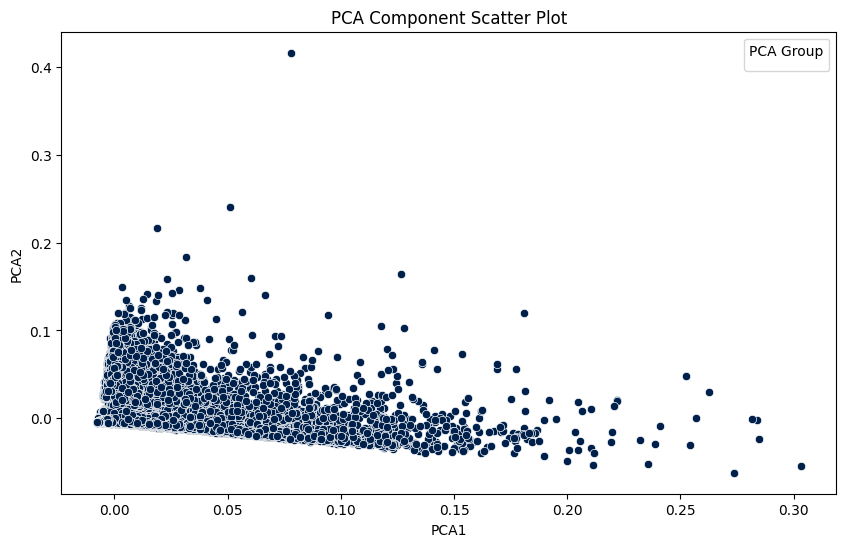

In [85]:
# Let's look where our customers fall interms of their cluster/ group
%matplotlib inline
plt.figure(figsize=(10, 6))
 
col_pal = ['#00204C', '#31446B', '#782170', '#958F78', '#00B050', '#FFE945']    
# Scatter plot with color based on 'Cluster'
sns.scatterplot(x='PCA1', y='PCA2', data=X, marker='o',color= col_pal[0])
    
plt.title('PCA Component Scatter Plot')
plt.xlabel('PCA1')
plt.ylabel('PCA2') 
plt.legend(title='PCA Group')

plt.show()

In [86]:
# Create a calss for XGB classifier model
clf = xgb.XGBClassifier()

In [87]:
from sklearn.feature_selection import SelectPercentile, chi2, f_classif
from sklearn.preprocessing import Binarizer, scale
from sklearn.model_selection import cross_val_score
import numpy as np

# List of percentiles to test
percentiles = [75,76, 77, 78, 80, 85, 90, 95, 96]

# Placeholder for tracking the best percentile and its score
best_percentile = 0
best_score = 0

# Iterate over the percentiles
for p in percentiles:
    X_bin = Binarizer().fit_transform(scale(X))
    
    # Chi-square selection
    selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, y)
    X_selected = selectChi2.transform(X_bin)
    
    # Evaluate model performance (example using cross-validation)
    model = clf 
    scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')  # Adjust scoring method as needed
    avg_score = np.mean(scores)
    
    print(f"Percentile: {p}, Score: {avg_score}")
    
    # Track the best score
    if avg_score > best_score:
        best_score = avg_score
        best_percentile = p

print(f"Best percentile: {best_percentile} with score: {best_score}")


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Percentile: 75, Score: 0.9601552223099186


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Percentile: 76, Score: 0.9601946856090502


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Percentile: 77, Score: 0.9601026045777428


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Percentile: 78, Score: 0.9601026045777428


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Percentile: 80, Score: 0.9601026045777428


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Percentile: 85, Score: 0.9601946856090502


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Percentile: 90, Score: 0.9601946856090502


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Percentile: 95, Score: 0.9601683767429623


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Percentile: 96, Score: 0.9601683767429623
Best percentile: 76 with score: 0.9601946856090502


> The feature best performs by using the selected 76% of the data.

In [88]:
# Percentile for the feature selection. Since the 76% percentile of the dataset scores highest, that's what we'll use.
p = 76
X_bin = Binarizer().fit_transform(scale(X))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, y)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(X, y)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [89]:
# Let's selected features based on their chi square
chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(X.columns) if chi2_selected[i]]


print('Chi2 selected: {}'.format(chi2_selected.sum()))

Chi2 selected: 256


In [90]:
# Identify which features meet the criteria based on the F-score selection.
# 'get_support()' returns a boolean mask indicating selected features.
# We use list comprehension to extract the names of the selected features.
# Finally, we print the total number of features selected by F_classif.
f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i,f in enumerate(X.columns) if f_classif_selected[i]]
print('F_classif selected {} features.'.format(f_classif_selected.sum()))


F_classif selected 256 features.


In [91]:
# Combine the results of Chi2 and F_classif feature selections using a logical AND operation.
# This ensures only the features selected by both methods are kept.
selected = chi2_selected & f_classif_selected
print('Chi2 & F_classif selected {} features'.format(selected.sum()))
features = [ f for f,s in zip(X.columns, selected) if s]

Chi2 & F_classif selected 239 features


### **Train Test Split** 

In [92]:
# Let's split the dataset
from sklearn import model_selection
X_sel = X[features]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_sel, y, random_state=1301, stratify=y, test_size=0.4)


## **Modelling**

In [93]:
# Create a class for our model
clf = xgb.XGBClassifier()

In [94]:
clf.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="auc",eval_set=[(X_train, y_train), (X_test, y_test)])

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83401	validation_1-auc:0.82399
[1]	validation_0-auc:0.84090	validation_1-auc:0.82568
[2]	validation_0-auc:0.84965	validation_1-auc:0.82835
[3]	validation_0-auc:0.85316	validation_1-auc:0.83004
[4]	validation_0-auc:0.85899	validation_1-auc:0.83344
[5]	validation_0-auc:0.86305	validation_1-auc:0.83442
[6]	validation_0-auc:0.86693	validation_1-auc:0.83571
[7]	validation_0-auc:0.87071	validation_1-auc:0.83522
[8]	validation_0-auc:0.87323	validation_1-auc:0.83451
[9]	validation_0-auc:0.87651	validation_1-auc:0.83568
[10]	validation_0-auc:0.87912	validation_1-auc:0.83654
[11]	validation_0-auc:0.88262	validation_1-auc:0.83595
[12]	validation_0-auc:0.88451	validation_1-auc:0.83629
[13]	validation_0-auc:0.88791	validation_1-auc:0.83501
[14]	validation_0-auc:0.89149	validation_1-auc:0.83406
[15]	validation_0-auc:0.89381	validation_1-auc:0.83399
[16]	validation_0-auc:0.89607	validation_1-auc:0.83410
[17]	validation_0-auc:0.89712	validation_1-auc:0.83413
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [95]:
from sklearn.metrics import roc_auc_score

# Make predictions with a specific number of trees (up to best_iteration)
probs = clf.predict_proba(X_sel, iteration_range=(0, clf.best_iteration))[:, 1]

# Calculate AUC
print('Overall AUC with best_iteration:', roc_auc_score(y, probs))


Overall AUC with best_iteration: 0.8601829110392522


## **Predictions - Test**

Now that we have trained our model on the training dataset, we can use it to make predictions on the unseen test data.

This section covers the basic process of using a trained ML model to generate predictions on new, previously unseen data and save them for submission/evaluation.

In [96]:
#Let's normalize the test dataset
test_normalized = normalize(test, axis=0)
#Create a class for PCA
pca = PCA(n_components=2)
#Let's fit the data to PCA
test_pca = pca.fit_transform(test_normalized)

In [97]:
#Create two pca components
test['PCA1'] = test_pca[:,0]
test['PCA2'] = test_pca[:,1]
sel_test = test[features]
#Use previous predictions based on the model
y_pred = clf.predict_proba(sel_test)

In [98]:
submission = pd.DataFrame({"ID":test.index, "TARGET":y_pred[:,1]})
submission.to_csv("submission.csv", index=False)

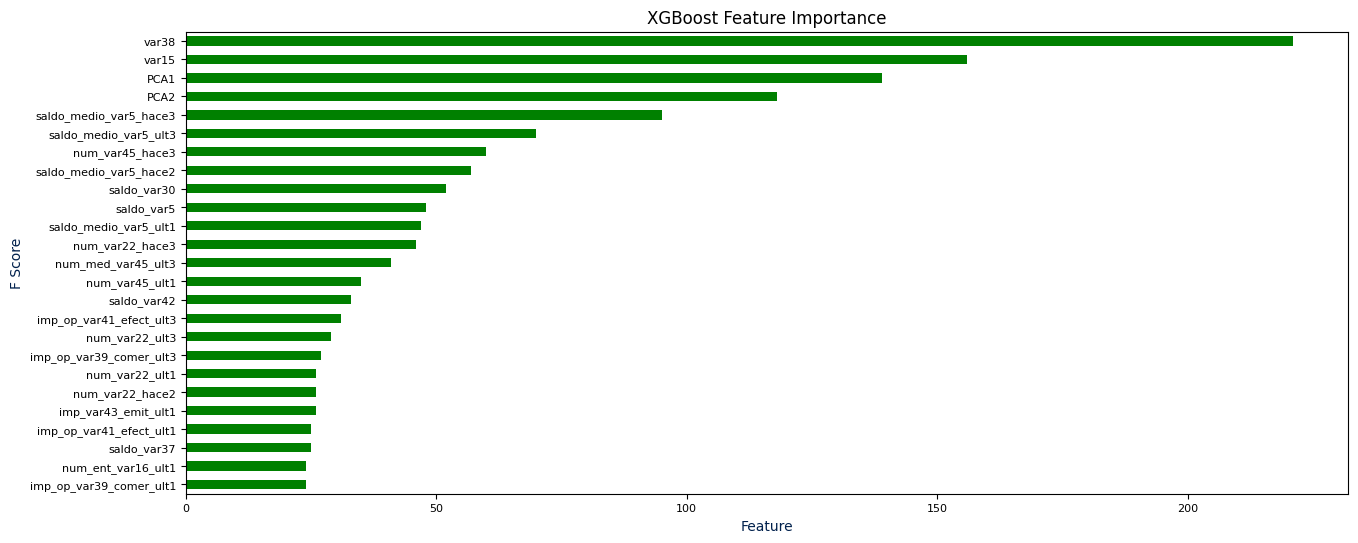

In [99]:
mapFeat = dict(zip(["f"+str(i) for i in range(len(features))],features))
# Get the feature importance scores from the model
ts = pd.Series(clf.get_booster().get_fscore())

# The top 25 most important features
plt.figure(figsize=(15,6))
ts.sort_values()[-25:].plot(kind="barh", title="XGBoost Feature Importance",color='green',fontsize=8)
plt.xlabel('Feature',fontsize=10,color =  col_pal[0])
plt.ylabel('F Score',fontsize=10,color =  col_pal[0]);
